In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

In [ ]:
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [ ]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [ ]:
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

In [ ]:
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
import cv2
import os

def load_hr_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(128, 128))
            images.append(img)
    return images

In [ ]:
def load_lr_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(32, 32))
            images.append(img)
    return images

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rudradevpradhan13","key":"22b5bba1e7300306a3542dc7d9676033"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 98% 145M/149M [00:00<00:00, 138MB/s]
100% 149M/149M [00:01<00:00, 154MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
lr_images = load_lr_images_from_folder("Testing/glioma")
hr_images = load_hr_images_from_folder("Testing/glioma")

In [ ]:
np_lr_images = np.array([lr_i / 255. for lr_i in lr_images])
np_hr_images = np.array([hr_i / 255. for hr_i in hr_images])

# Split data into train and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(np_lr_images, np_hr_images, test_size=0.2, random_state=42)

In [ ]:
np_lr_images = []
np_hr_images = []
for lr_i in lr_images:
    lr_i = lr_i/255.
    np_lr_images.append(np.array(lr_i))
for hr_i in hr_images:
    hr_i = hr_i/255.
    np_hr_images.append(np.array(hr_i))

In [ ]:
np_lr_images = np.array(np_lr_images)
np_hr_images = np.array(np_hr_images)

In [ ]:
lr_train, lr_test, hr_train, hr_test = train_test_split(np_lr_images, np_hr_images,
                                                      test_size=0.2, random_state=42)

In [ ]:
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block=16)

In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)

In [ ]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [ ]:
vgg = build_vgg((128,128,3))
vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")

In [ ]:
gan_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model_1 (Functional)        (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, 1)                    3824928   ['model_1[0][0]']             
                                                          1                                 

In [ ]:
batch_size = 16
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
# batch_size = 16
# test_lr_batches = []
# test_hr_batches = []
# for it in range(int(hr_test.shape[0] / batch_size)):
#     start_idx = it * batch_size
#     end_idx = start_idx + batch_size
#     train_hr_batches.append(hr_test[start_idx:end_idx])
#     train_lr_batches.append(lr_test[start_idx:end_idx])

In [ ]:
!mkdir -p saved_model

In [ ]:
epochs = 5

g_losses = []

for e in range(epochs):
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_label = np.zeros((len(lr_imgs), 1))
        real_label = np.ones((len(hr_imgs), 1))

        fake_imgs = generator.predict_on_batch(lr_imgs)

        discriminator.trainable = True
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

        discriminator.trainable = False
        image_features = vgg.predict(hr_imgs)
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])


        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_loss = np.mean(g_losses)
    d_loss = np.mean(d_losses)

    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0:
        generator.save("/saved_model/gen_e_"+ str(e+1) +".h5")

1/1 [==============================] - 3s 3s/step
epoch: 1 g_loss: 32.654595947265626 d_loss: 1.4610708509685841
1/1 [==============================] - 2s 2s/step
epoch: 2 g_loss: 31.813507016499837 d_loss: 1.0412240909446855
1/1 [==============================] - 3s 3s/step
epoch: 3 g_loss: 30.940086279975045 d_loss: 0.6837139419234907
1/1 [==============================] - 2s 2s/step
epoch: 4 g_loss: 29.658165582021077 d_loss: 0.6276108596604504
1/1 [==============================] - 2s 2s/step
epoch: 5 g_loss: 28.410628356933593 d_loss: 0.6125156176637276


In [ ]:
print(g_losses)
print(d_losses)

[40.78068161010742, 34.339534759521484, 33.308170318603516, 33.23401641845703, 35.36668395996094, 34.39708709716797, 30.665630340576172, 32.16618347167969, 32.639991760253906, 29.26939582824707, 26.844940185546875, 31.416568756103516, 30.753093719482422, 33.2022819519043, 31.43467903137207, 39.11246109008789, 33.3576545715332, 31.178619384765625, 31.78693199157715, 33.69369125366211, 32.442317962646484, 29.2076416015625, 29.795242309570312, 30.907604217529297, 28.015539169311523, 24.603273391723633, 29.539026260375977, 29.321659088134766, 32.275325775146484, 29.34928321838379, 35.5672492980957, 31.105501174926758, 30.37029266357422, 31.612287521362305, 31.363821029663086, 32.098690032958984, 27.375106811523438, 28.794967651367188, 28.81719398498535, 27.142301559448242, 23.281259536743164, 27.114559173583984, 26.544200897216797, 29.27347183227539, 27.437768936157227, 32.449066162109375, 27.494140625, 26.477783203125, 27.311147689819336, 28.191789627075195, 27.418251037597656, 24.5013065

ValueError: x and y must have same first dimension, but have shapes (75,) and (15,)

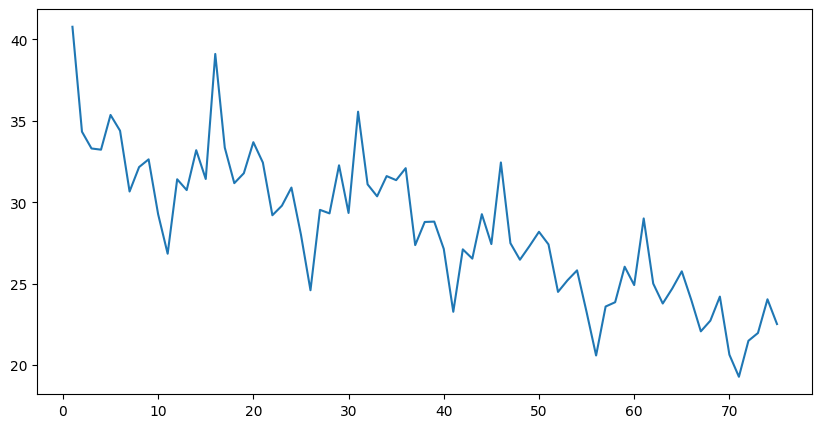

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
epochs = len(g_losses)  # Assuming g_losses and d_losses have the same length
plt.plot(range(1, epochs + 1), g_losses, label='Generator Loss')
# Plotting only the first element of each sublist in d_losses
plt.plot(range(1, epochs + 1), [d_loss[0] for d_loss in d_losses], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
